In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn')

In [74]:
def plot_assim_result(result, X_nature, X_obs, rmse, stableidx, result_label=None):
    # plot assimilation result
    ts = np.arange(0, time, dt)
    t_obs = np.arange(0, time, obs_timeintv)

    # plot nature run and assimilation result
    fig, axs = plt.subplots(nrows=4, figsize=(20, 12))
    for i in range(3):
        axs[i].plot(ts, result[i,:], label=result_label)
        axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
        axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
    # plot RMSE and stable index
    axs[3].plot(ts, rmse, c='grey', lw=0.8)
    bool_idx = stableidx > 0
    axs[3].scatter(ts[~bool_idx], rmse[~bool_idx], s=20, c='white')
    axs[3].scatter(ts[bool_idx], rmse[bool_idx], s=20, c=stableidx[bool_idx], cmap='Reds')
    axs[3].scatter(ts[::int(obs_timeintv/dt)], rmse[::int(obs_timeintv/dt)], s=5, marker='x')

    axs[0].set_title('X')
    axs[1].set_title('Y')
    axs[2].set_title('Z')
    axs[3].set_title('RMSE and instability')
    axs[3].set_xlabel('time')

    axs[0].legend()
    plt.tight_layout()
    return fig, axs


def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err


def lorenz63_fdm(x0, ts, sigma=None, r=None, b=None):
    """Solve lorenz63 with finit difference method"""  
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    size = ts.size
    dt = ts[1] - ts[0]
    
    x = np.zeros((size,))
    y = np.zeros((size,))
    z = np.zeros((size,))
    x[0] = x0[0]
    y[0] = x0[1]
    z[0] = x0[2]
    
    for i in range(1, size):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (r*x[i-1] - y[i-1] - x[i-1]*z[i-1]) * dt
        z[i] = z[i-1] + (x[i-1]*y[i-1] - b*z[i-1]) * dt
    
    return np.vstack((x, y, z))


def M(xi, yi, zi, dt, sigma=None, r=None, b=None):
    """tangent linear model for lorenz63_fdm"""
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    M = np.array([
        [1-sigma*dt, sigma*dt, 0],
        [r*dt-zi*dt, 1-dt, -xi*dt],
        [yi*dt, xi*dt, 1-b*dt]
    ])
    return M


def stability_index_lorenz63(x, y, z, sigma=None, r=None, b=None):
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
        
    M = np.array([
        [-sigma, sigma, 0],
        [r-z, -1, -x],
        [y, x, -b]
    ])
    
    eigv, P = np.linalg.eig(M)
    r = eigv.real
    if np.all(r<0):
        # stable case
        return r.sum()
    else:
        # unstable case
        r[r<0] = 0
        return r.sum()

In [31]:
time = 16
dt = 0.01
ts = np.arange(0, time, dt)
X0 = np.array([[8, 0, 30]]).T
X_nature = lorenz63_fdm(X0.ravel(), ts)

In [32]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [2, 2, 2] 
random_state = [20, 21, 22]

# assimilate observation parameters
obs_timeintv = 0.08
obs_intv = int(obs_timeintv / dt)
cycle_num = int(time / obs_timeintv)

# construct observation error
size = int(time/dt)
X_obs_err = np.zeros((3, size))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst)
    
X_obs = X_nature + X_obs_err
X_obs = X_obs[:,::obs_intv]

In [33]:
X_ini = X_nature[:,[0]] + np.array([[50], [40], [60]])

In [138]:
import warnings
from scipy.optimize import minimize


class DAbase:
    def __init__(self, model, dt, store_history=False):
        self._isstore = store_history
        self._params = {'alpha': 0, 'inflat': 1}
        self.model = model
        self.dt = dt
        self.X_ini = None
        
    def set_params(self, param_list, **kwargs):
        for key, value in kwargs.items():
            if key in param_list:
                self._params[key] = kwargs.get(key)
            else:
                raise ValueError(f'Invalid parameter: {key}')
        
    def _check_params(self, param_list):
        missing_params = []
        for var in param_list:
            if self._params.get(var) is None:
                missing_params.append(var)
        return missing_params


class ExtendedKF(DAbase):
    def __init__(self, model, dt, store_history=False):
        super().__init__(model, dt, store_history)
        self._param_list = [
            'X_ini', 
            'obs', 
            'obs_interv', 
            'Pb', 
            'R', 
            'H_func', 
            'H', 
            'M', 
            'alpha', 
            'inflat'
        ]
        
    def list_params(self):
        return self._param_list
        
    def set_params(self, **kwargs):
        super().set_params(self._param_list, **kwargs)
        
    def _check_params(self):
        if self._params.get('H_func') is None:
            H_func = lambda arr: arr
            self._params['H_func'] = H_func
        if self._params.get('H') is None:
            H = np.eye(self._params.get('R').shape[0])
            self._params['H'] = H
            
        missing_params = super()._check_params(self._param_list)
        if missing_params:
            raise ValueError(f"Missing parameters: {missing_params}")
            
    def _analysis(self, xb, yo, Pb, R, H_func=None, H=None):
        if H_func is None:
            K = Pb @ np.linalg.inv(Pb + R)
            xa = xb + K @ (yo - xb)
            Pa = (np.eye(len(xb)) - K) @ Pb
        else:
            K = Pb @ H.T @ np.linalg.inv(H @ Pb @ H.T + R)
            xa = xb + K @ (yo - H_func(xb))
            Pa = (np.eye(len(xb)) - K @ H) @ Pb
        return (xa, Pa)
    
    def cycle(self):
        self._check_params()
        
        model = self.model
        dt = self.dt
        cycle_len = self._params['obs_interv']
        cycle_num = self._params['obs'].shape[1]
        
        xb = self._params['X_ini']
        obs = self._params['obs']
        Pb = self._params['Pb']
        R = self._params['R']
        H_func = self._params['H_func']
        H = self._params['H']
        alpha = self._params['alpha']
        inflat = self._params['inflat']
        
        background = np.zeros((xb.size, cycle_len*cycle_num))
        analysis = np.zeros_like(background)
        
        t_start = 0
        ts = np.arange(t_start, cycle_len*dt, dt)
        
        for nc in range(cycle_num):
            # analysis and forecast
            xa, Pa = self._analysis(xb, obs[:,[nc]], Pb, R, H_func, H)
            x_forecast = model(xa.ravel(), ts)
            
            # store result of background and analysis field
            idx1 = nc*cycle_len
            idx2 = (nc+1)*cycle_len
            analysis[:,idx1:idx2] = x_forecast
            background[:,[idx1]] = xb
            background[:,(idx1+1):idx2] = x_forecast[:,1:]
            
            # for next cycle
            M = self._params['M'](xb[0,0], xb[1,0], xb[2,0])
            Pb = alpha * Pb + (1-alpha) * M @ Pa @ M.T
            Pb *= inflat
            xb = x_forecast[:,[-1]]
            t_start = int(ts[-1] + dt)
            ts = np.arange(t_start, t_start+cycle_len*dt, dt)
            
        self.background = background
        self.analysis = analysis
        
        
class OI(DAbase):
    def __init__(self, model, dt, store_history=False):
        super().__init__(model, dt, store_history)
        self._param_list = [
            'X_ini', 
            'obs', 
            'obs_interv', 
            'Pb', 
            'R', 
            'H_func', 
            'H'
        ]
        
    def list_params(self):
        return self._param_list
        
    def set_params(self, **kwargs):
        super().set_params(self._param_list, **kwargs)
        
    def _check_params(self):
        if self._params.get('H_func') is None:
            H_func = lambda arr: arr
            self._params['H_func'] = H_func
        if self._params.get('H') is None:
            H = np.eye(self._params.get('R').shape[0])
            self._params['H'] = H
            
        missing_params = super()._check_params(self._param_list)
        if missing_params:
            raise ValueError(f"Missing parameters: {missing_params}")
            
    def _analysis(self, xb, yo, Pb, R, H_func=None, H=None):
        if H_func is None:
            K = Pb @ np.linalg.inv(Pb + R)
            xa = xb + K @ (yo - xb)
            Pa = (np.eye(len(xb)) - K) @ Pb
        else:
            K = Pb @ H.T @ np.linalg.inv(H @ Pb @ H.T + R)
            xa = xb + K @ (yo - H_func(xb))
            Pa = (np.eye(len(xb)) - K @ H) @ Pb
        return (xa, Pa)
    
    def cycle(self):
        self._check_params()
        
        model = self.model
        dt = self.dt
        cycle_len = self._params['obs_interv']
        cycle_num = self._params['obs'].shape[1]
        
        xb = self._params['X_ini']
        obs = self._params['obs']
        Pb = self._params['Pb']
        R = self._params['R']
        H_func = self._params['H_func']
        H = self._params['H']
        
        background = np.zeros((xb.size, cycle_len*cycle_num))
        analysis = np.zeros_like(background)
        
        t_start = 0
        ts = np.arange(t_start, cycle_len*dt, dt)
        
        for nc in range(cycle_num):
            # analysis and forecast
            xa, _ = self._analysis(xb, obs[:,[nc]], Pb, R, H_func, H)
            x_forecast = model(xa.ravel(), ts)
            
            # store result of background and analysis field
            idx1 = nc*cycle_len
            idx2 = (nc+1)*cycle_len
            analysis[:,idx1:idx2] = x_forecast
            background[:,[idx1]] = xb
            background[:,(idx1+1):idx2] = x_forecast[:,1:]
            
            # for next cycle
            xb = x_forecast[:,[-1]]
            t_start = int(ts[-1] + dt)
            ts = np.arange(t_start, t_start+cycle_len*dt, dt)
            
        self.background = background
        self.analysis = analysis
        

class M3DVar(DAbase):
    def __init__(self, model, dt, store_history=False):
        super().__init__(model, dt, store_history)
        self._param_list = [
            'X_ini', 
            'obs', 
            'obs_interv', 
            'Pb', 
            'R', 
            'H_func', 
        ]
        
    def list_params(self):
        return self._param_list
        
    def set_params(self, **kwargs):
        super().set_params(self._param_list, **kwargs)
        
    def _check_params(self):
        if self._params.get('H_func') is None:
            H_func = lambda arr: arr
            self._params['H_func'] = H_func
            
        missing_params = super()._check_params(self._param_list)
        if missing_params:
            raise ValueError(f"Missing parameters: {missing_params}")
            
    def _3dvar_costfunction(self, x, xb, yo, invPb, invR, H_func=None, H=None):
        """
        x and xb is 1d array with shape (n,), the other is 2d matrix
        """
        x = x[:,np.newaxis]
        xb = xb[:,np.newaxis]

        if H_func is None:
            innovation = yo - x
        else:
            innovation = yo - H_func(x) 

        return 0.5 * (xb-x).T @ invPb @ (xb-x) + 0.5 * innovation.T @ invR @ innovation

    def _analysis(self, xb, yo, Pb, R, H_func=None):    
        if H_func is None:
            innovation = yo - xb
        else:
            innovation = yo - H_func(xb)

        invPb = np.linalg.inv(Pb)
        invR = np.linalg.inv(R)
        cost_func = lambda x: self._3dvar_costfunction(x, xb.ravel(), yo, invPb, invR)

        return minimize(cost_func, xb.ravel(), method='BFGS').x
    
    def cycle(self):
        self._check_params()
        
        model = self.model
        dt = self.dt
        cycle_len = self._params['obs_interv']
        cycle_num = self._params['obs'].shape[1]
        
        xb = self._params['X_ini']
        obs = self._params['obs']
        Pb = self._params['Pb']
        R = self._params['R']
        H_func = self._params['H_func']
        
        background = np.zeros((xb.size, cycle_len*cycle_num))
        analysis = np.zeros_like(background)
        
        t_start = 0
        ts = np.arange(t_start, cycle_len*dt, dt)
        
        for nc in range(cycle_num):
            # analysis and forecast
            xa = self._analysis(xb, obs[:,[nc]], Pb, R, H_func)
            x_forecast = model(xa.ravel(), ts)
            
            # store result of background and analysis field
            idx1 = nc*cycle_len
            idx2 = (nc+1)*cycle_len
            analysis[:,idx1:idx2] = x_forecast
            background[:,[idx1]] = xb
            background[:,(idx1+1):idx2] = x_forecast[:,1:]
            
            # for next cycle
            xb = x_forecast[:,[-1]]
            t_start = int(ts[-1] + dt)
            ts = np.arange(t_start, t_start+cycle_len*dt, dt)
            
        self.background = background
        self.analysis = analysis

## 3DVar

In [139]:
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.2

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)


tdv_params = {
    'X_ini': X_ini, 
    'obs': X_obs, 
    'obs_interv': 8, 
    'Pb': Pb, 
    'R': R, 
    'H_func': None, 
}

tdv = M3DVar(lorenz63_fdm, dt)
tdv.set_params(**tdv_params)
tdv.cycle()
tdv.analysis

array([[16.92249825, 14.82964159, 12.78982152, ..., 10.60163252,
        10.37981488, 10.13037518],
       [-4.00606834, -5.56855918, -6.66852101, ...,  8.38345616,
         7.88541785,  7.39708918],
       [37.46994642, 35.79282101, 34.01254841, ..., 31.90698085,
        31.94491124, 31.91153872]])

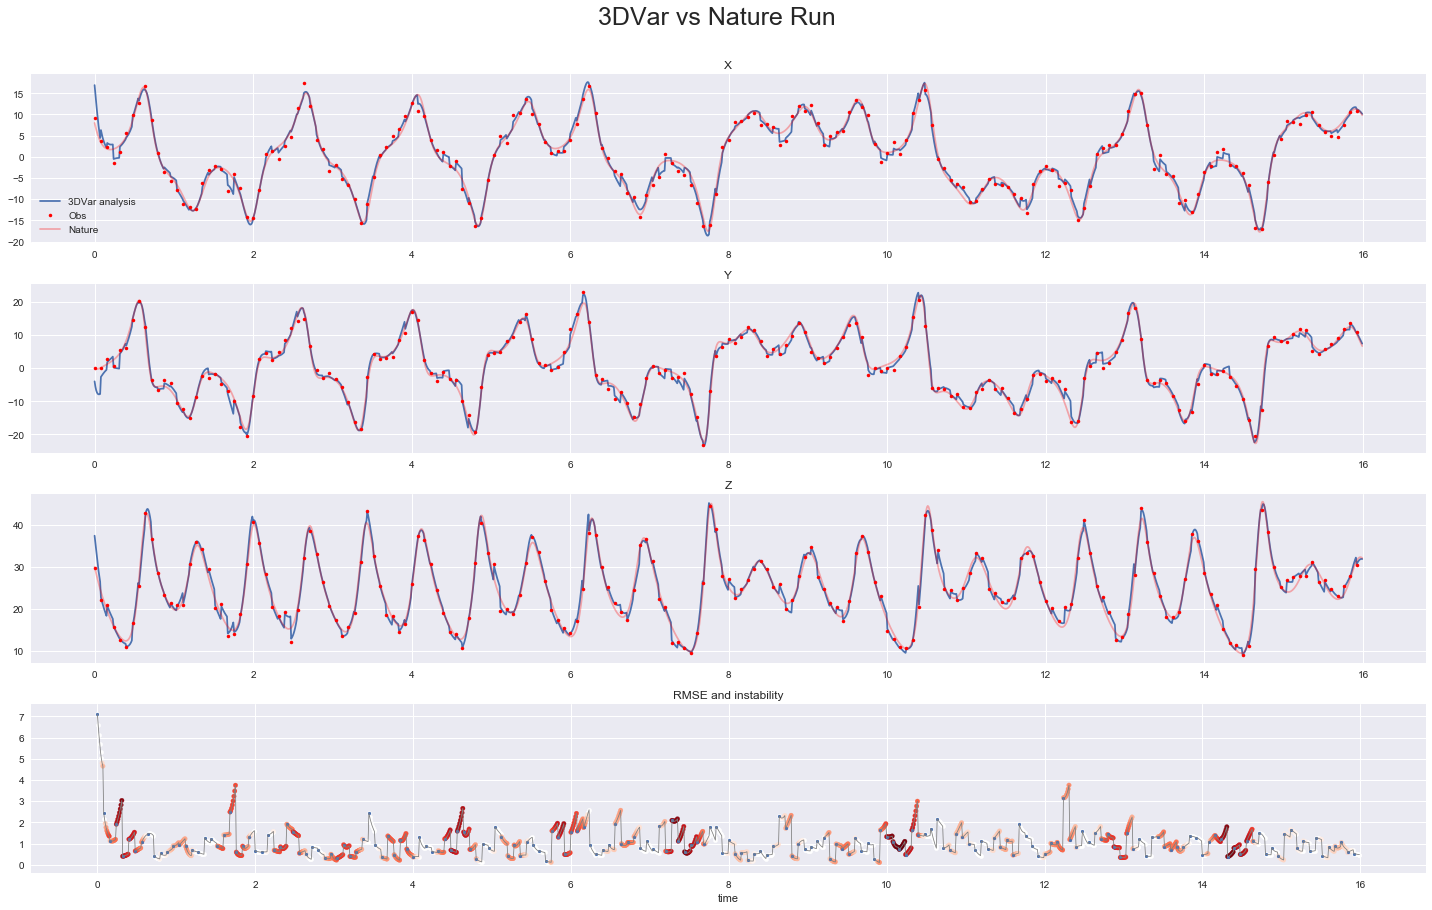

In [140]:
# calculate RMSE and stable index
rmse_tdv = np.sqrt(np.mean((tdv.analysis-X_nature)**2, axis=0))
stableidx = []
for x in tdv.analysis.T:
    stableidx.append(stability_index_lorenz63(*x))
stableidx = np.array(stableidx)

# plot
fig, axs = plot_assim_result(tdv.analysis, X_nature, X_obs, rmse_oi, stableidx, '3DVar analysis')
fig.suptitle('3DVar vs Nature Run', fontsize=25, y=1.05);

## OI

In [128]:
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.2

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)


oi_params = {
    'X_ini': X_ini, 
    'obs': X_obs, 
    'obs_interv': 8, 
    'Pb': Pb, 
    'R': R, 
    'H_func': None, 
    'H': None
}

oi = OI(lorenz63_fdm, dt)
oi.set_params(**oi_params)
oi.cycle()
oi.analysis

array([[16.9224981 , 14.82964136, 12.78982121, ..., 10.6016313 ,
        10.37981439, 10.13037538],
       [-4.00606927, -5.56856017, -6.66852203, ...,  8.38346212,
         7.88542433,  7.39709607],
       [37.46994694, 35.79282136, 34.01254862, ..., 31.90697585,
        31.94490691, 31.91153513]])

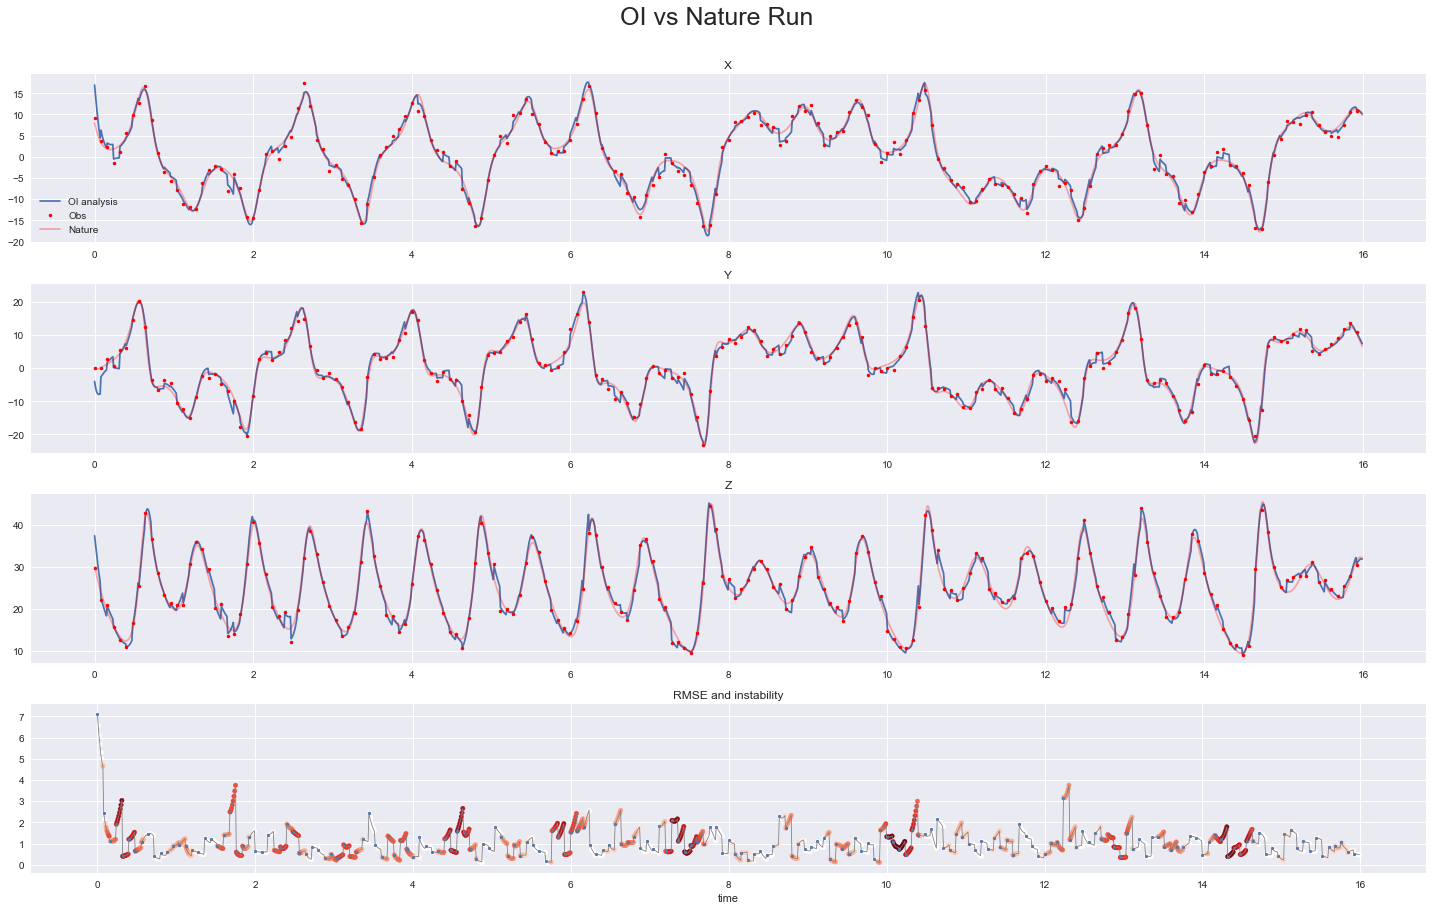

In [132]:
# calculate RMSE and stable index
rmse_oi = np.sqrt(np.mean((oi.analysis-X_nature)**2, axis=0))
stableidx = []
for x in oi.analysis.T:
    stableidx.append(stability_index_lorenz63(*x))
stableidx = np.array(stableidx)

# plot
fig, axs = plot_assim_result(oi.analysis, X_nature, X_obs, rmse_oi, stableidx, 'OI analysis')
fig.suptitle('OI vs Nature Run', fontsize=25, y=1.05);

## EKF

In [124]:
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.2

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)


ekf_params = {
    'X_ini': X_ini, 
    'obs': X_obs, 
    'obs_interv': 8, 
    'Pb': Pb, 
    'R': R, 
    'H_func': None, 
    'H': None, 
    'M': lambda xi, yi, zi: M(xi, yi, zi, dt),
    'alpha': 0.3,
    'inflat': 1.5
}

ekf = ExtendedKF(lorenz63_fdm, dt)
ekf.set_params(**ekf_params)
ekf.cycle()
ekf.analysis

array([[16.9224981 , 14.82964136, 12.78982121, ..., 10.69010085,
        10.4917783 , 10.25998679],
       [-4.00606927, -5.56856017, -6.66852203, ...,  8.70687541,
         8.17386313,  7.6468092 ],
       [37.46994694, 35.79282136, 34.01254862, ..., 32.1715559 ,
        32.2444215 , 32.24215386]])

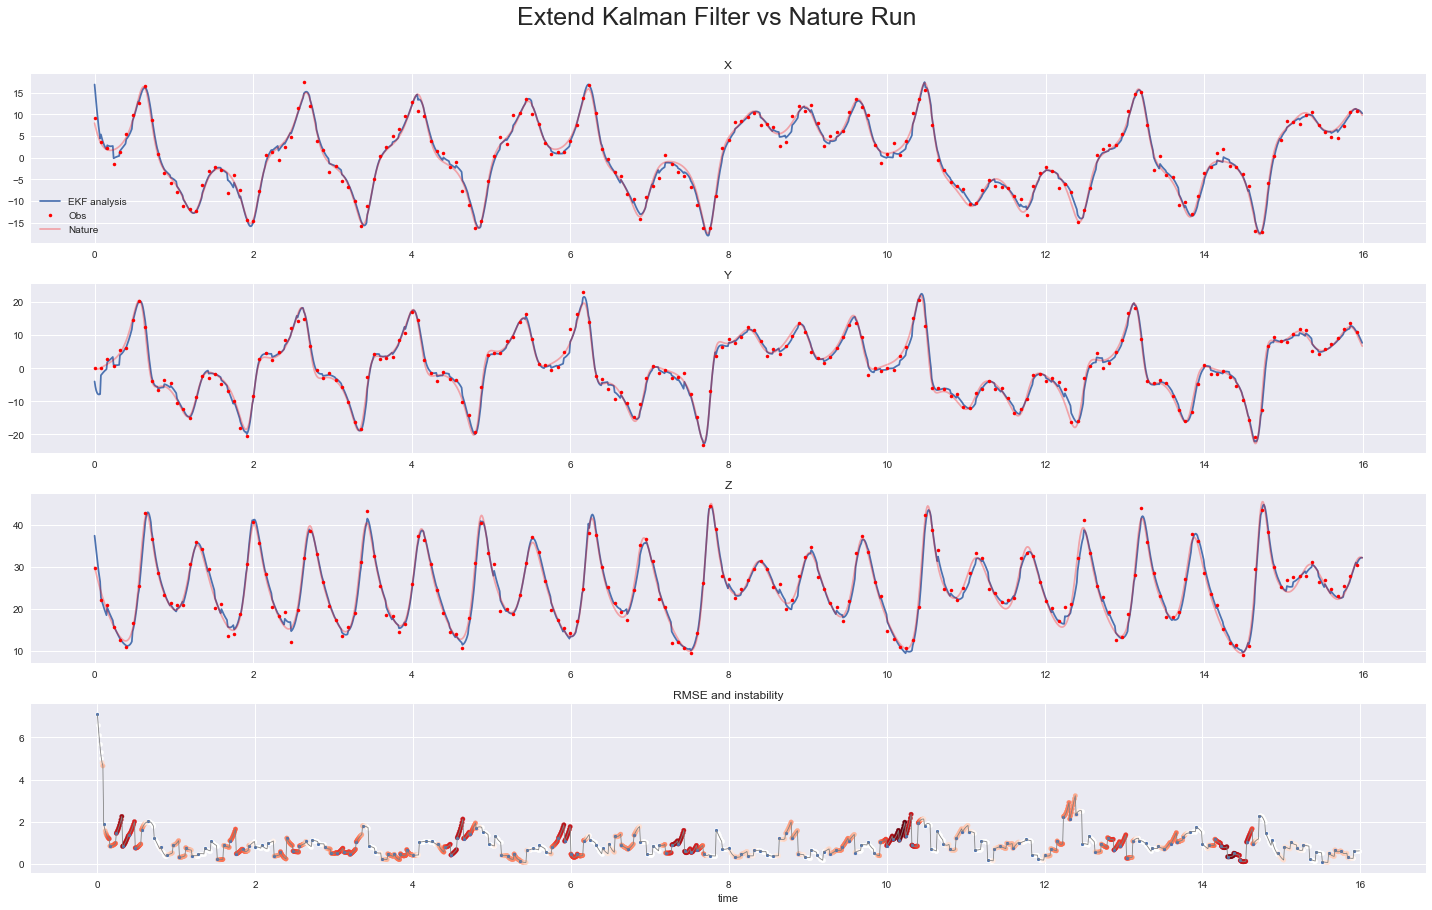

In [125]:
# calculate RMSE and stable index
rmse_ekf = np.sqrt(np.mean((ekf.analysis-X_nature)**2, axis=0))
stableidx = []
for x in ekf.analysis.T:
    stableidx.append(stability_index_lorenz63(*x))
stableidx = np.array(stableidx)

# plot
fig, axs = plot_assim_result(ekf.analysis, X_nature, X_obs, rmse_ekf, stableidx, 'EKF analysis')
fig.suptitle('Extend Kalman Filter vs Nature Run', fontsize=25, y=1.05);